In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Nadam, RMSprop # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
import shutil
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle

In [6]:
!kaggle datasets download -d kylegraupe/skin-cancer-binary-classification-dataset

 98% 22.0M/22.5M [00:02<00:00, 19.8MB/s]
100% 22.5M/22.5M [00:02<00:00, 11.2MB/s]


In [7]:
!unzip /content/skin-cancer-binary-classification-dataset.zip

Archive:  /content/skin-cancer-binary-classification-dataset.zip
  inflating: Skin_Data/Cancer/Testing/1714-02.jpg  
  inflating: Skin_Data/Cancer/Testing/1718-2.jpg  
  inflating: Skin_Data/Cancer/Testing/1777-1.JPG  
  inflating: Skin_Data/Cancer/Testing/1780.1.JPG  
  inflating: Skin_Data/Cancer/Testing/1780.JPG  
  inflating: Skin_Data/Cancer/Testing/1789-02.JPG  
  inflating: Skin_Data/Cancer/Testing/1811-3.JPG  
  inflating: Skin_Data/Cancer/Testing/1847 (7).JPG  
  inflating: Skin_Data/Cancer/Testing/1847.JPG  
  inflating: Skin_Data/Cancer/Testing/1861-02.JPG  
  inflating: Skin_Data/Cancer/Testing/1864-1.JPG  
  inflating: Skin_Data/Cancer/Testing/1877(2).JPG  
  inflating: Skin_Data/Cancer/Testing/1877.JPG  
  inflating: Skin_Data/Cancer/Testing/1905.JPG  
  inflating: Skin_Data/Cancer/Testing/1969-1.JPG  
  inflating: Skin_Data/Cancer/Testing/1969-2.JPG  
  inflating: Skin_Data/Cancer/Testing/1988-01.JPG  
  inflating: Skin_Data/Cancer/Testing/1991 (1).JPG  
  inflating: Ski

In [8]:
!pip install -q Augmentor
import Augmentor

In [9]:
path_to_training_dataset = '/content/Skin_Data/'
class_names = ['Cancer','Non_Cancer']
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i + '/Training', output_directory='/content/sample_data/Train/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(5000)

Initialised with 42 image(s) found.
Output directory set to /content/sample_data/Train/Cancer.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=206x200 at 0x7A52D3FF3C40>: 100%|██████████| 5000/5000 [02:31<00:00, 32.92 Samples/s]


Initialised with 42 image(s) found.
Output directory set to /content/sample_data/Train/Non_Cancer.

Processing <PIL.Image.Image image mode=RGB size=160x140 at 0x7A53201A7EB0>: 100%|██████████| 5000/5000 [01:03<00:00, 78.18 Samples/s]


In [10]:
data_dir = '/content/Skin_Data'  # Update this to your dataset directory
output_dir = '/content/sample_data/Test'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create subdirectories for train and valid (no test directory)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)


# Define the classes for binary classification
classes = ['Cancer', 'Non_Cancer']

# Move data from source to train/valid folders
for class_name in classes:
    class_dir = os.path.join(data_dir,class_name,"Testing")

    # Create subdirectories for train and valid within each class
    os.makedirs(os.path.join(output_dir, 'test', class_name), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, 'valid', class_name), exist_ok=True)

    # List all files in the current class directory
    files = os.listdir(class_dir)


    # Move files to train
    for file in files:
        source_path = os.path.join(class_dir, file)
        dest_path = os.path.join(output_dir, 'test', class_name, file)
        shutil.copyfile(source_path, dest_path)

print("Data preprocessing for binary classification complete.")

Data preprocessing for binary classification complete.


In [11]:
batch_size = 16
img_height = 180
img_width = 180

In [12]:
output_dir = '/content/sample_data/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  shuffle = True,
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  shuffle = True,
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/sample_data/Test/test',
  seed=123,
  validation_split = 0.9,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 204 files belonging to 2 classes.
Using 183 files for validation.


In [57]:
input_shape = (img_height,img_width,3)
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=input_shape)])
model.add(Conv2D(16,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [58]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer= opt,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [59]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
500/500 [==============================] - 22s 35ms/step - loss: 0.6006 - accuracy: 0.9521 - val_loss: 6.8438 - val_accuracy: 0.6815
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2786 - accuracy: 0.9836 - val_loss: 0.1322 - val_accuracy: 0.9885
Epoch 3/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2988 - accuracy: 0.9876 - val_loss: 0.0890 - val_accuracy: 0.9890
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.0255 - accuracy: 0.9983 - val_loss: 4.7578e-10 - val_accuracy: 1.0000
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3509 - accuracy: 0.9881 - val_loss: 8.0622 - val_accuracy: 0.8860
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.3248 - accuracy: 0.9886 - val_loss: 4.3015e-12 - val_accuracy: 1.0000
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.0151 - accuracy: 0.9991 - val_loss: 1.5038e-19 - v

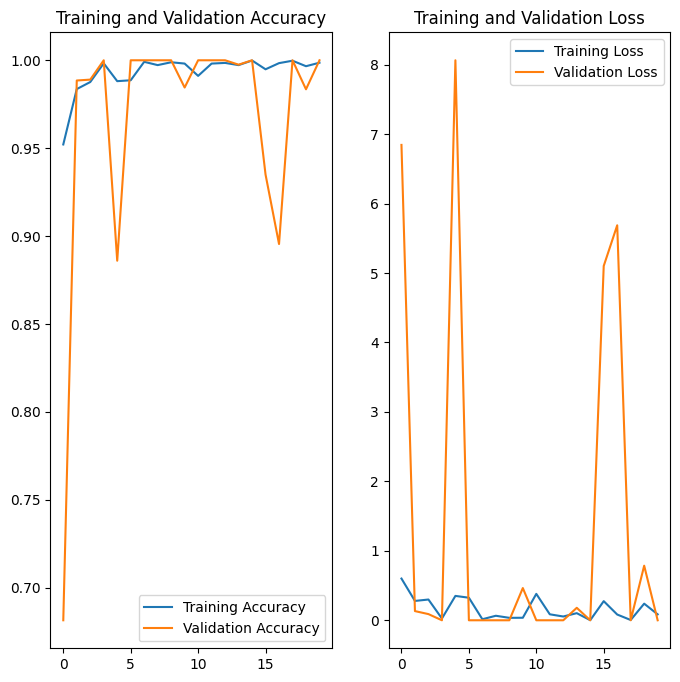

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, verbose=1)

12/12 [==============================] - 0s 11ms/step - loss: 33.9434 - accuracy: 0.8525


In [72]:
model.save("Binary Cancer 85%acc.h5")

In [62]:
true_categories = np.array(tf.concat([y for x, y in test_ds], axis=0))

In [63]:
predictions = np.array(model.predict(test_ds))
pred_categories = []
for pred in predictions:
  if(pred[0] >= 0.5):
    pred_categories.append(1)
  else:
    pred_categories.append(0)
pred_categories = np.array(pred_categories)

12/12 [==============================] - 0s 9ms/step


In [64]:
true_categories

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [65]:
pred_categories

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1])

In [66]:
pd.crosstab(true_categories,pred_categories)

col_0,0,1
row_0,,
0,12,25
1,26,120


In [67]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(true_categories,pred_categories))

              precision    recall  f1-score   support

           0       0.32      0.32      0.32        37
           1       0.83      0.82      0.82       146

    accuracy                           0.72       183
   macro avg       0.57      0.57      0.57       183
weighted avg       0.72      0.72      0.72       183



In [68]:
accuracy_score(true_categories,pred_categories)

0.7213114754098361

In [69]:
from tensorflow.keras.preprocessing import image

In [70]:
img = image.load_img('/content/sample_data/Test/test/Cancer/1992.JPG',target_size =(180,180))

In [71]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =model.predict(x)
if(float(pred[0]) >= 0.5):
    print("Non Cancer")
else:
    print("Cancer")
score = float(pred[0])
print(f"This image is {100 * (1 - score):.2f}% Cancer and {100 * score:.2f}% Non Cancer.")

1/1 [==============================] - 0s 263ms/step
Cancer
This image is 100.00% Cancer and 0.00% Non Cancer.
